In [76]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import numpy as np

import os
import gc
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import lightgbm as lgb
from scipy.stats import hmean

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
target = 'redemption_status'
id_cols = ['id', 'campaign_id']

In [78]:
train = pd.read_csv("train.csv", index_col=None)
test = pd.read_csv("test.csv", index_col=None)
submission = pd.read_csv("sample_submission.csv", index_col=None)

train.shape, test.shape, submission.shape

((78369, 5), (50226, 4), (50226, 2))

# Preparing data

In [79]:
campaign_data = pd.read_csv("campaign_data.csv", index_col=None)
coupon_item_mapping = pd.read_csv("coupon_item_mapping.csv", index_col=None)
item_data = pd.read_csv("item_data.csv", index_col=None)
customer_transaction_data = pd.read_csv("customer_transaction_data.csv", index_col=None)
customer_data = pd.read_csv("customer_demographics.csv", index_col=None)

In [80]:
campaign_data['end_date'] = pd.to_datetime(campaign_data['end_date'], format='%d/%m/%y')
campaign_data['start_date'] = pd.to_datetime(campaign_data['start_date'], format='%d/%m/%y')
campaign_data['_campaign_duration'] = (campaign_data['end_date'] - campaign_data['start_date']).dt.days

In [81]:
customer_transaction_data = pd.merge(customer_transaction_data, item_data, on='item_id', how='left')

customer_transaction_data['coupon_discount'] = customer_transaction_data['coupon_discount']*-1
customer_transaction_data['other_discount'] = customer_transaction_data['other_discount']*-1

customer_transaction_data['coupon_discount_pct'] = (customer_transaction_data['coupon_discount'] /
                                                    (customer_transaction_data['selling_price'] +
                                                     customer_transaction_data['coupon_discount']))

customer_transaction_data['other_discount_pct'] = (customer_transaction_data['other_discount'] /
                                                   (customer_transaction_data['selling_price'] +
                                                    customer_transaction_data['other_discount']))

customer_transaction_data['date'] = pd.to_datetime(customer_transaction_data['date'])

In [82]:
train = pd.merge(train, customer_data, on='customer_id', how='left')
test = pd.merge(test, customer_data, on='customer_id', how='left')

train = pd.merge(train, campaign_data, on='campaign_id', how='left')
test = pd.merge(test, campaign_data, on='campaign_id', how='left')

In [83]:
def split_vals(x, campaigns):
    return (x[~x.campaign_id.isin(campaigns)].reset_index(drop=True), 
            x[x.campaign_id.isin(campaigns)].reset_index(drop=True))

In [84]:
coupon_item_mapping = pd.merge(coupon_item_mapping, item_data, on='item_id', how='left')

for col in tqdm(['item_id', 'brand', 'brand_type', 'category']):
    agg_df = coupon_item_mapping.groupby('coupon_id')[col].nunique().to_frame('_unique_'+col+'_per_coupon')
    agg_df = agg_df.reset_index()

    train = pd.merge(train, agg_df, on='coupon_id', how='left')
    test = pd.merge(test, agg_df, on='coupon_id', how='left')

In [85]:
coupon_item_set = coupon_item_mapping.groupby('coupon_id').item_id.apply(set).to_frame("coupon_items")

In [86]:
train = pd.merge(train, coupon_item_set, on='coupon_id', how='left')
test = pd.merge(test, coupon_item_set, on='coupon_id', how='left')

In [87]:
customer_transaction_data = customer_transaction_data.drop_duplicates()
desired_customers = train['customer_id']+test['customer_id']
customer_transaction_data = customer_transaction_data[customer_transaction_data.customer_id.isin(desired_customers)]
customer_transaction_data = customer_transaction_data.reset_index(drop=True)

# train test split

In [88]:
from sklearn.metrics import roc_auc_score
def process_data(df):
    for col in ['age_range', 'marital_status', 'family_size', 
                'no_of_children', 'campaign_type']:
        df[col] = df[col].astype('category')
#         df[col] = df[col].cat.codes
        
    return df

def scoring_func(x, y): return roc_auc_score

In [89]:
train = process_data(train)
test = process_data(test)

In [90]:
train = train.sort_values(by='start_date').reset_index(drop=True)

In [91]:
valid_campaigns = [9, 10, 11, 12, 13]
train_df, valid_df = split_vals(train, valid_campaigns)
train_df.shape, valid_df.shape

((45540, 20), (32829, 20))

In [92]:
min_campaign_startdate = valid_df.start_date.min()
customer_transaction_data_v = customer_transaction_data[customer_transaction_data.date<min_campaign_startdate]
customer_transaction_data_v = customer_transaction_data_v.reset_index(drop=True)

customer_transaction_data_v.shape

(982515, 12)

## feature engineering

In [93]:
def generate_agg_features(overall):
    agg_df = overall.groupby('coupon_id').agg({"campaign_id": ["nunique"],
                                               "customer_id": ["nunique"], 
                                               "id":["count"]})
    agg_df.columns = ["coupon_" + a +"_" + b for a,b in agg_df.columns]
    agg_df = agg_df.reset_index()

    overall = pd.merge(overall, agg_df, on='coupon_id', how='left')

    agg_df = overall.groupby('campaign_id').agg({"coupon_id": ["nunique"],
                                                 "customer_id": ["nunique"], 
                                                 "id":["count"]})
    agg_df.columns = ["campaign_" + a +"_" + b for a,b in agg_df.columns]
    agg_df = agg_df.reset_index()
    overall = pd.merge(overall, agg_df, on='campaign_id', how='left')

    agg_df = overall.groupby('customer_id').agg({"campaign_id": ["nunique"],
                                                 "coupon_id": ["nunique"],
                                                 "id":["count"]
                                                })
    agg_df.columns = ["customer_" + a +"_" + b for a,b in agg_df.columns]
    agg_df = agg_df.reset_index()
    overall = pd.merge(overall, agg_df, on='customer_id', how='left')
    
    return overall

In [94]:
def gen_customer_feature(customer_transaction_data, campaign_start_dates):
    customer_seen_items = pd.DataFrame()
    for col in tqdm(campaign_start_dates):
        temp = customer_transaction_data.groupby('customer_id').agg({"item_id":[set, "nunique"],
                                                                     "quantity":"sum",
                                                                     "coupon_discount_pct":"mean",
                                                                     "other_discount_pct":"mean",
                                                                    })
        temp.columns = ['seen_items', 'item_number', 'quantity', 
                        'coupon_discount_pct_mean', 'other_discount_pct_mean']
        temp['qty_per_item'] = temp['quantity'] / temp['item_number']
        temp['_start_date'] = col
        temp = temp.reset_index()

        customer_seen_items = pd.concat((customer_seen_items, temp), axis=0)

    return customer_seen_items

In [95]:
def merging_customer_feature(customer_seen_items, data):
    customer_seen_items = customer_seen_items.sort_values(by='_start_date').reset_index(drop=True)
    data = data.sort_values(by='start_date').reset_index(drop=True)

    data = pd.merge_asof(data,
                            customer_seen_items,
                            left_on='start_date',
                            right_on='_start_date',
                            direction='backward',
                            by='customer_id')
    
#     data['seen_items_count'] = 0
    seen_items_index = data['seen_items'].notnull()
    data.loc[seen_items_index, 
             'seen_items_count'] = data.loc[seen_items_index].progress_apply(lambda x: 
                                                                             len(x['coupon_items'] & x['seen_items']), 
                                                                             axis=1)
    
    return data

In [96]:
train['is_train'] = 1
test['is_train'] = 0

overall = pd.concat((train, test), ignore_index=True, sort=False)
overall = generate_agg_features(overall)

train = overall[overall['is_train']==1].reset_index(drop=True)
test = overall[overall['is_train']==0].reset_index(drop=True)

In [97]:
campaign_start_dates = np.unique(np.append(train.start_date.unique(), 
                                           test.start_date.unique()))

campaign_start_dates = train.start_date.unique()
customer_features = gen_customer_feature(customer_transaction_data, campaign_start_dates)

train = merging_customer_feature(customer_features, train)
test = merging_customer_feature(customer_features, test)

In [98]:
train_df['is_train'] = 1
valid_df['is_train'] = 0

overall = pd.concat((train_df, valid_df), ignore_index=True, sort=False)
overall = generate_agg_features(overall)

train_df = overall[overall['is_train']==1].reset_index(drop=True)
valid_df = overall[overall['is_train']==0].reset_index(drop=True)

In [99]:
campaign_start_dates = np.unique(np.append(train_df.start_date.unique(), 
                                           valid_df.start_date.unique()))

customer_features = gen_customer_feature(customer_transaction_data_v, campaign_start_dates)
train_df = merging_customer_feature(customer_features, train_df)
valid_df = merging_customer_feature(customer_features, valid_df)

In [100]:
del overall
gc.collect()

28

In [101]:
def generate_coupon_features(customer_transaction_data, train, test):
    temp = customer_transaction_data.groupby('item_id').agg({"customer_id":"nunique",
                                                             "other_discount":"sum",
                                                             "coupon_discount":"sum"
                                                            })
    temp['coupon_discount_per_customer'] = temp['coupon_discount'] / temp['customer_id']
    temp = temp.reset_index()
    temp = temp.rename(columns={'customer_id':'item_customers', 'quantity':'item_qty'})

    coupon_item_agg = pd.merge(coupon_item_mapping, temp, on='item_id', how='left')
    temp = coupon_item_agg.groupby('coupon_id').agg({"coupon_discount_per_customer":["mean", "std"],
                                                     "item_customers":["mean","std"],
                                                        })
    col_names = [a + "_" + b for a,b in temp.columns]
    temp.columns = col_names
    temp = temp.reset_index()

    original_col = list(temp.columns)
    renamed_col = [col if col!='coupon_id' else col for col in temp.columns]
    temp = temp.rename(columns=dict(zip(original_col, renamed_col)))

    train = pd.merge(train, temp, on='coupon_id', how='left')
    test = pd.merge(test, temp, on='coupon_id', how='left')
    
    return train, test

In [102]:
train, test = generate_coupon_features(customer_transaction_data, train, test)
train_df, valid_df = generate_coupon_features(customer_transaction_data_v, train_df, valid_df)

## modeling

In [103]:
for data in [train, test, train_df, valid_df]:
    print(data.start_date.min(), data.start_date.max(),
         data.end_date.min(), data.end_date.max())

2012-08-12 00:00:00 2013-05-19 00:00:00 2012-09-21 00:00:00 2013-07-05 00:00:00
2013-07-15 00:00:00 2013-10-21 00:00:00 2013-08-16 00:00:00 2013-12-20 00:00:00
2012-08-12 00:00:00 2013-02-16 00:00:00 2012-09-21 00:00:00 2013-04-05 00:00:00
2013-03-11 00:00:00 2013-05-19 00:00:00 2013-04-12 00:00:00 2013-07-05 00:00:00


## prediction without seen item count feature

In [104]:
predictors = [
    'coupon_id',
    'campaign_type',
    '_campaign_duration',
    'income_bracket',
    '_unique_item_id_per_coupon',
    '_unique_brand_per_coupon',
    '_unique_category_per_coupon',
    'coupon_discount_pct_mean',
    'other_discount_pct_mean',
    'qty_per_item',
    'coupon_discount_per_customer_mean',
    'item_customers_mean',
    'coupon_id_count',
    'campaign_id_count',
    'customer_id_count',
    'item_number']

In [105]:
m = lgb.LGBMClassifier(n_estimators=10000, 
#                                   max_depth=4, 
                                  learning_rate=0.0011, 
                                  colsample_bytree=0.5)

m.fit(train_df[predictors],
      train_df[target],
      eval_set=[(valid_df[predictors],
                 valid_df[target])],
      eval_metric='auc', 
      early_stopping_rounds=500,
      verbose=100)

train_score = m.predict_proba(train_df[predictors])[:,1]
valid_score = m.predict_proba(valid_df[predictors])[:,1]
print("train {} valid {}".format(roc_auc_score(train_df[target], train_score),
                                 roc_auc_score(valid_df[target], valid_score)))

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's auc: 0.865677	valid_0's binary_logloss: 0.0624888
[200]	valid_0's auc: 0.868064	valid_0's binary_logloss: 0.0602325
[300]	valid_0's auc: 0.871235	valid_0's binary_logloss: 0.0587067
[400]	valid_0's auc: 0.873618	valid_0's binary_logloss: 0.057457
[500]	valid_0's auc: 0.874558	valid_0's binary_logloss: 0.0564186
[600]	valid_0's auc: 0.874581	valid_0's binary_logloss: 0.0556062
[700]	valid_0's auc: 0.874067	valid_0's binary_logloss: 0.054917
[800]	valid_0's auc: 0.874032	valid_0's binary_logloss: 0.0543513
[900]	valid_0's auc: 0.873677	valid_0's binary_logloss: 0.0538781
[1000]	valid_0's auc: 0.873356	valid_0's binary_logloss: 0.0534836
Early stopping, best iteration is:
[525]	valid_0's auc: 0.874953	valid_0's binary_logloss: 0.0562121
train 0.9758663600480069 valid 0.8749533428434377


In [106]:
predictors = [
    'coupon_id',
    'campaign_type',
    '_campaign_duration',
    'income_bracket',
    '_unique_item_id_per_coupon',
    '_unique_brand_per_coupon',
    '_unique_category_per_coupon',
    'coupon_discount_pct_mean',
    'other_discount_pct_mean',
    'qty_per_item',
    'coupon_discount_per_customer_mean',
    'item_customers_mean',
    'coupon_id_count',
    'campaign_id_count',
    'customer_id_count',
    'item_number',
    'seen_items_count']

In [107]:
m = lgb.LGBMClassifier(n_estimators=10000, 
#                                   max_depth=4, 
                                  learning_rate=0.0011, 
                                  colsample_bytree=0.5)

m.fit(train_df[predictors],
      train_df[target],
      eval_set=[(valid_df[predictors],
                 valid_df[target])],
      eval_metric='auc', 
      early_stopping_rounds=500,
      verbose=100)

train_score = m.predict_proba(train_df[predictors])[:,1]
valid_score = m.predict_proba(valid_df[predictors])[:,1]
print("train {} valid {}".format(roc_auc_score(train_df[target], train_score),
                                 roc_auc_score(valid_df[target], valid_score)))

Training until validation scores don't improve for 500 rounds.
[100]	valid_0's auc: 0.924575	valid_0's binary_logloss: 0.0594632
[200]	valid_0's auc: 0.926038	valid_0's binary_logloss: 0.0560648
[300]	valid_0's auc: 0.927151	valid_0's binary_logloss: 0.0537675
[400]	valid_0's auc: 0.927529	valid_0's binary_logloss: 0.051973
[500]	valid_0's auc: 0.927827	valid_0's binary_logloss: 0.0505883
[600]	valid_0's auc: 0.927891	valid_0's binary_logloss: 0.049515
[700]	valid_0's auc: 0.927768	valid_0's binary_logloss: 0.048612
[800]	valid_0's auc: 0.927634	valid_0's binary_logloss: 0.0478412
[900]	valid_0's auc: 0.927415	valid_0's binary_logloss: 0.0472192
[1000]	valid_0's auc: 0.927356	valid_0's binary_logloss: 0.0466603
[1100]	valid_0's auc: 0.926894	valid_0's binary_logloss: 0.0462305
Early stopping, best iteration is:
[666]	valid_0's auc: 0.928032	valid_0's binary_logloss: 0.0488844
train 0.9969230718435255 valid 0.9280317761645901


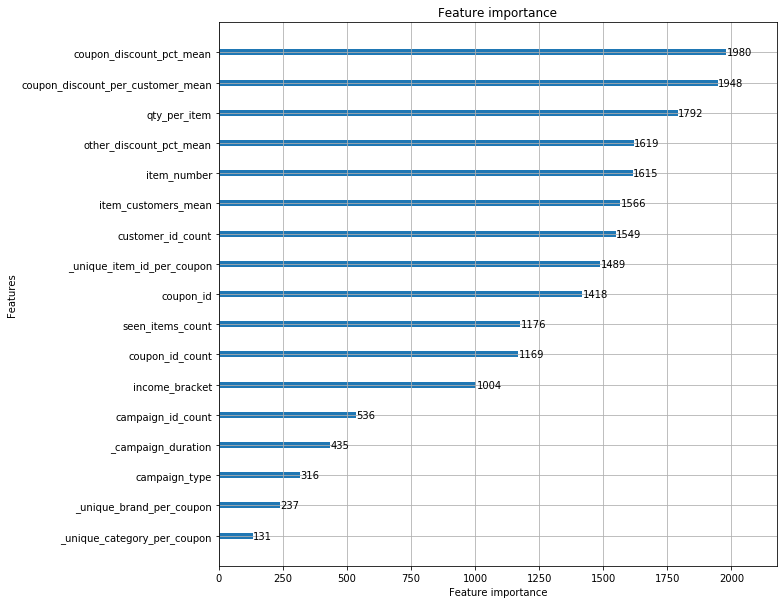

In [108]:
lgb.plot_importance(m, figsize=(10,10))

In [109]:
m.best_iteration_

666

## single model based prediction

In [110]:
# X_train = train[predictors].copy()
# y_train = train[target]

# X_test = test[predictors].copy()
# y_test = test[target]

In [111]:
# m_final = lgb.LGBMClassifier(n_estimators=1800, 
# #                                   max_depth=4, 
#                                   learning_rate=0.0011, 
#                                   colsample_bytree=0.5)

# m_final.fit(X_train, y_train)
# print("test score {} ".format(roc_auc_score(y_test, 
#                                             m_final.predict_proba(X_test)[:,1])))

# Final Solution - GroupKFold CV 

In [112]:
train = train.sort_values(by='start_date').reset_index(drop=True)

In [113]:
X_train = train.copy()
y_train = train[target]

X_test = test.copy()
y_test = test[target]

In [114]:
group = X_train['campaign_id'].values

In [115]:
predictors = ['coupon_id',
 'campaign_type',
 '_campaign_duration',
 'income_bracket',
 '_unique_item_id_per_coupon',
 '_unique_brand_per_coupon',
 '_unique_category_per_coupon',
 'coupon_id_count',
 'campaign_id_count',
 'customer_id_count',
]

predictors2 = ['coupon_discount_pct_mean',
 'other_discount_pct_mean',
 'qty_per_item',
 'seen_items_count',
 'coupon_discount_per_customer_mean',
 'item_customers_mean']
    
drop_cols = ['start_date', 'customer_id', 'coupon_items', 'id']
drop_cols2 = ['seen_items', '_start_date', 'item_number', 
              'quantity', 'coupon_discount_per_customer_std', 'item_customers_std']

In [116]:
X_train = X_train[predictors+drop_cols+[target]]
X_test = X_test[predictors+predictors2]

In [117]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, cross_val_predict, GroupKFold
from sklearn.metrics import roc_auc_score
def scoring(y_true, y_hat):
    return roc_auc_score(y_true, y_hat)

kf = GroupKFold(n_splits=5)
    
val_scores = []
true_vals = []
prediction_vals = []
test_prediction = []
for n_fold, (train_index, test_index) in (enumerate(kf.split(X_train, y_train, groups=group))):
    X_train_temp = X_train.iloc[train_index].reset_index(drop=True)
    X_val_temp = X_train.iloc[test_index].reset_index(drop=True)
    X_test_temp = X_test.reset_index(drop=True)
    
    # determining transaction history based of minimum campaign start date
    min_campaign_startdate = X_val_temp.start_date.min()
    customer_transaction_data_v = customer_transaction_data[customer_transaction_data.date<min_campaign_startdate]
    customer_transaction_data_v = customer_transaction_data_v.reset_index(drop=True)

    # finding unique campaign start date
    campaign_start_dates = np.unique(np.append(X_train_temp.start_date.unique(), 
                                               X_val_temp.start_date.unique()))

    # customer features
    customer_features = gen_customer_feature(customer_transaction_data_v, campaign_start_dates)
    X_train_temp = merging_customer_feature(customer_features, X_train_temp)
    X_val_temp = merging_customer_feature(customer_features, X_val_temp)
    
    # coupon features
    X_train_temp, X_val_temp = generate_coupon_features(customer_transaction_data_v, 
                                                        X_train_temp, 
                                                        X_val_temp)
    
    y_train_temp = X_train_temp[target]
    X_train_temp = X_train_temp.drop(target, axis=1)
    y_val_temp = X_val_temp[target]
    X_val_temp = X_val_temp.drop(target, axis=1)

    X_train_temp.drop(drop_cols+drop_cols2, axis=1, inplace=True)
    X_val_temp.drop(drop_cols+drop_cols2, axis=1, inplace=True)

    model = lgb.LGBMClassifier(n_estimators=10000, 
#                                   max_depth=4, 
#                       seed=seed,
                      learning_rate=0.0011, 
                      colsample_bytree=0.4)

    model.fit(X_train_temp,
          y_train_temp,
          eval_set=[(X_val_temp,
                     y_val_temp)],
          eval_metric='auc', 
          early_stopping_rounds=500, 
          verbose=0)

    # valid prediction
    y_hat_valid = model.predict_proba(X_val_temp)[:, 1]
    
    # test prediction
    X_test_temp = X_test_temp.reindex(columns=X_train_temp.columns)
    y_hat_test = model.predict_proba(X_test_temp)[:, 1]

    prediction_vals.extend(y_hat_valid)
    true_vals.extend(y_val_temp)
    test_prediction.append(y_hat_test)

    # calculate score 
    score_valid = scoring(y_val_temp, y_hat_valid)
    val_scores.append(score_valid)
    print("Fold {} Score {}".format(n_fold+1, score_valid))
print("CV Score is {}".format(scoring(true_vals, prediction_vals)))


Fold 1 Score 0.9370836774015966



Fold 2 Score 0.9491528585852864



Fold 3 Score 0.8387392779341019



Fold 4 Score 0.8700730064048234



Fold 5 Score 0.8068118481464194
CV Score is 0.9012977044344515


In [118]:
preds = np.mean(test_prediction, axis=0)

In [119]:
# roc_auc_score(y_test, preds)